# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
# from mlfs import config
# settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/fredrikstrom/Documents/KTH_Dokument/Scalable ML/labs/mlfs-book


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 17, 12, 15, 610586)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
locations_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
locations = json.loads(locations_str)
country=locations[0]['country']
city=locations[0]['city']
#street=location['street']

2025-11-18 17:12:15,626 INFO: Initializing external client
2025-11-18 17:12:15,626 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 17:12:16,337 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 17:12:17,111 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286301


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=3,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-18 17:12:22,585 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/546991 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/107609 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/121822 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/114796 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/123825 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/108164 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/142093 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28068 elapsed<00:00 remaining<?

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='3.776104E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['int', 'float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [7]:
print(retrieved_xgboost_model.feature_names_in_)

['station_id' 'pm25_lag_1d' 'pm25_lag_2d' 'pm25_lag_3d'
 'temperature_2m_mean' 'precipitation_sum' 'wind_speed_10m_max'
 'wind_direction_10m_dominant']


## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [8]:
weather_fg = fs.get_feature_group(
    name="weather",
    version=1,
)

# Only take Munich rows and dates >= today
batch_data = weather_fg.filter(
    (weather_fg.city == city) & (weather_fg.date >= today)
).read()

air_quality_fg = fs.get_feature_group(name="air_quality_munich", version=1)
air_quality_df = air_quality_fg.read()

# Last row per station
air_quality_df = air_quality_df.sort_values(["station_id", "date"])
latest_per_station = air_quality_df.groupby("station_id").tail(1)
station_ids = latest_per_station["station_id"].unique()

# Duplicate weather rows for each station_id
batch_data = batch_data.assign(key=1).merge(
    pd.DataFrame({"station_id": station_ids, "key": [1] * len(station_ids)}),
    on="key"
).drop(columns=["key"])

# Add lag features per station
batch_data = batch_data.merge(
    latest_per_station[["station_id", "pm25_lag_1d", "pm25_lag_2d", "pm25_lag_3d"]],
    on="station_id",
    how="left",
)

batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.15s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.28s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,station_id,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d
0,2025-11-22 00:00:00+00:00,-2.10,0.0,1.609969,333.435028,munich,6037,34.0,47.0,69.0
1,2025-11-22 00:00:00+00:00,-2.10,0.0,1.609969,333.435028,munich,6041,33.0,38.0,61.0
2,2025-11-22 00:00:00+00:00,-2.10,0.0,1.609969,333.435028,munich,6042,41.0,41.0,55.0
3,2025-11-22 00:00:00+00:00,-2.10,0.0,1.609969,333.435028,munich,6043,23.0,36.0,55.0
4,2025-11-22 00:00:00+00:00,-2.10,0.0,1.609969,333.435028,munich,6044,33.0,45.0,66.0
5,2025-11-21 00:00:00+00:00,-0.90,0.4,11.792404,31.263678,munich,6037,34.0,47.0,69.0
6,2025-11-21 00:00:00+00:00,-0.90,0.4,11.792404,31.263678,munich,6041,33.0,38.0,61.0
7,2025-11-21 00:00:00+00:00,-0.90,0.4,11.792404,31.263678,munich,6042,41.0,41.0,55.0
8,2025-11-21 00:00:00+00:00,-0.90,0.4,11.792404,31.263678,munich,6043,23.0,36.0,55.0
9,2025-11-21 00:00:00+00:00,-0.90,0.4,11.792404,31.263678,munich,6044,33.0,45.0,66.0


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [9]:
# 1) Sort by station + date
batch_data = batch_data.sort_values(["station_id", "date"]).reset_index(drop=True)

feature_cols = [
    "station_id",
    "pm25_lag_1d",
    "pm25_lag_2d",
    "pm25_lag_3d",
    "temperature_2m_mean",
    "precipitation_sum",
    "wind_speed_10m_max",
    "wind_direction_10m_dominant",
]

# Ensure numeric dtypes for features
batch_data[feature_cols] = (
    batch_data[feature_cols]
    .apply(pd.to_numeric, errors="coerce")
    .astype("float64")
)

# 2) Build initial lag state per station_id from latest_per_station
# (this assumes you still have latest_per_station from the previous cell)
lag_init = latest_per_station.set_index("station_id")[
    ["pm25", "pm25_lag_1d", "pm25_lag_2d"]
]

lag_state = {
    sid: {
        "lag1": row["pm25"],
        "lag2": row["pm25_lag_1d"],
        "lag3": row["pm25_lag_2d"],
    }
    for sid, row in lag_init.iterrows()
}

preds = []

# 3) Walk through forecast rows and update lags per station
for i in range(len(batch_data)):
    sid = batch_data.loc[i, "station_id"]

    # if for some reason a station_id has no history, you can default to 0s
    if sid not in lag_state:
        lag_state[sid] = {"lag1": 0.0, "lag2": 0.0, "lag3": 0.0}

    st = lag_state[sid]

    # set lags for CURRENT forecast row
    batch_data.loc[i, "pm25_lag_1d"] = st["lag1"]
    batch_data.loc[i, "pm25_lag_2d"] = st["lag2"]
    batch_data.loc[i, "pm25_lag_3d"] = st["lag3"]

    # build 1-row numeric DataFrame for prediction
    X_row = batch_data.loc[[i], feature_cols].astype("float64")
    y_hat = float(retrieved_xgboost_model.predict(X_row)[0])
    preds.append(y_hat)

    # update this station's lag state for the NEXT day
    st["lag3"] = st["lag2"]
    st["lag2"] = st["lag1"]
    st["lag1"] = y_hat

batch_data["predicted_pm25"] = preds
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,station_id,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,predicted_pm25
0,2025-11-19 00:00:00+00:00,4.75,0.0,4.896529,162.897186,munich,6037.0,NaN,34.000000,47.000000,40.898365
1,2025-11-20 00:00:00+00:00,1.60,0.3,10.144082,297.474335,munich,6037.0,40.898365,NaN,34.000000,45.127396
2,2025-11-21 00:00:00+00:00,-0.90,0.4,11.792404,31.263678,munich,6037.0,45.127396,40.898365,NaN,53.483021
3,2025-11-22 00:00:00+00:00,-2.10,0.0,1.609969,333.435028,munich,6037.0,53.483021,45.127396,40.898365,60.634655
4,2025-11-23 00:00:00+00:00,-3.30,0.0,11.165805,88.152428,munich,6037.0,60.634655,53.483021,45.127396,62.845455
5,2025-11-24 00:00:00+00:00,-2.45,0.2,3.758510,73.300674,munich,6037.0,62.845455,60.634655,53.483021,59.061325
6,2025-11-19 00:00:00+00:00,4.75,0.0,4.896529,162.897186,munich,6041.0,17.000000,33.000000,38.000000,31.575855
7,2025-11-20 00:00:00+00:00,1.60,0.3,10.144082,297.474335,munich,6041.0,31.575855,17.000000,33.000000,37.572281
8,2025-11-21 00:00:00+00:00,-0.90,0.4,11.792404,31.263678,munich,6041.0,37.572281,31.575855,17.000000,48.630638
9,2025-11-22 00:00:00+00:00,-2.10,0.0,1.609969,333.435028,munich,6041.0,48.630638,37.572281,31.575855,51.162853


In [10]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         30 non-null     datetime64[us, Etc/UTC]
 1   temperature_2m_mean          30 non-null     float64                
 2   precipitation_sum            30 non-null     float64                
 3   wind_speed_10m_max           30 non-null     float64                
 4   wind_direction_10m_dominant  30 non-null     float64                
 5   city                         30 non-null     object                 
 6   station_id                   30 non-null     float64                
 7   pm25_lag_1d                  29 non-null     float64                
 8   pm25_lag_2d                  29 non-null     float64                
 9   pm25_lag_3d                  29 non-null     float64                
 10  pred

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [11]:
meta_df = (
    air_quality_df
    .sort_values("date")
    .groupby("station_id")
    .tail(1)[["station_id", "street", "city", "country"]]
    .drop_duplicates("station_id")
)

# Attach metadata to each forecast row
batch_data = batch_data.merge(meta_df, on="station_id", how="left")

rename_map = {}
drop_cols = []

for col in batch_data.columns:
    if col.endswith("_x") or col.endswith("_y"):
        base = col[:-2]  # strip _x / _y
        if base in ["city", "street", "country"]:
            # prefer the *_x version and drop *_y
            if col.endswith("_x"):
                rename_map[col] = base
            else:
                drop_cols.append(col)

# Apply renames and drops
batch_data = batch_data.rename(columns=rename_map).drop(columns=drop_cols, errors="ignore")

# Sort by date + station
batch_data = batch_data.sort_values(["date", "station_id"]).reset_index(drop=True)

# Define days_before_forecast_day based only on date (same for all stations on same day)
base_date = batch_data["date"].min()
batch_data["days_before_forecast_day"] = (
    (batch_data["date"] - base_date).dt.days + 1
)

batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,station_id,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,4.75,0.0,4.896529,162.897186,munich,6037.0,NaN,34.000000,47.000000,40.898365,Munich,germany,1
1,2025-11-19 00:00:00+00:00,4.75,0.0,4.896529,162.897186,munich,6041.0,17.000000,33.000000,38.000000,31.575855,"Johanneskirchen, München, Germany",germany,1
2,2025-11-19 00:00:00+00:00,4.75,0.0,4.896529,162.897186,munich,6042.0,34.000000,41.000000,41.000000,42.316105,"Landshuter Allee, München, Germany",germany,1
3,2025-11-19 00:00:00+00:00,4.75,0.0,4.896529,162.897186,munich,6043.0,25.000000,23.000000,36.000000,37.230106,"Lothstraße, München, Germany",germany,1
4,2025-11-19 00:00:00+00:00,4.75,0.0,4.896529,162.897186,munich,6044.0,21.000000,33.000000,45.000000,38.413574,"Stachus, München, Germany",germany,1
5,2025-11-20 00:00:00+00:00,1.60,0.3,10.144082,297.474335,munich,6037.0,40.898365,NaN,34.000000,45.127396,Munich,germany,2
6,2025-11-20 00:00:00+00:00,1.60,0.3,10.144082,297.474335,munich,6041.0,31.575855,17.000000,33.000000,37.572281,"Johanneskirchen, München, Germany",germany,2
7,2025-11-20 00:00:00+00:00,1.60,0.3,10.144082,297.474335,munich,6042.0,42.316105,34.000000,41.000000,48.613743,"Landshuter Allee, München, Germany",germany,2
8,2025-11-20 00:00:00+00:00,1.60,0.3,10.144082,297.474335,munich,6043.0,37.230106,25.000000,23.000000,38.657497,"Lothstraße, München, Germany",germany,2
9,2025-11-20 00:00:00+00:00,1.60,0.3,10.144082,297.474335,munich,6044.0,38.413574,21.000000,33.000000,44.608315,"Stachus, München, Germany",germany,2


In [12]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         30 non-null     datetime64[us, Etc/UTC]
 1   temperature_2m_mean          30 non-null     float64                
 2   precipitation_sum            30 non-null     float64                
 3   wind_speed_10m_max           30 non-null     float64                
 4   wind_direction_10m_dominant  30 non-null     float64                
 5   city                         30 non-null     object                 
 6   station_id                   30 non-null     float64                
 7   pm25_lag_1d                  29 non-null     float64                
 8   pm25_lag_2d                  29 non-null     float64                
 9   pm25_lag_3d                  29 non-null     float64                
 10  pred

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-18 17:12:36,100 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



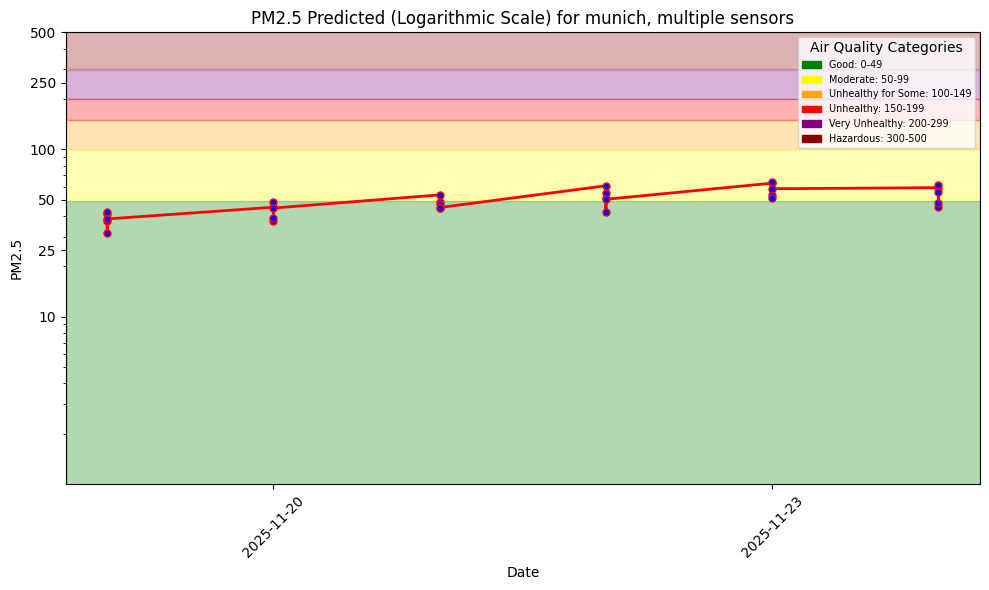

In [13]:
# pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
# plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

# plt.show()

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, "multiple sensors", batch_data, pred_file_path)
plt.show()

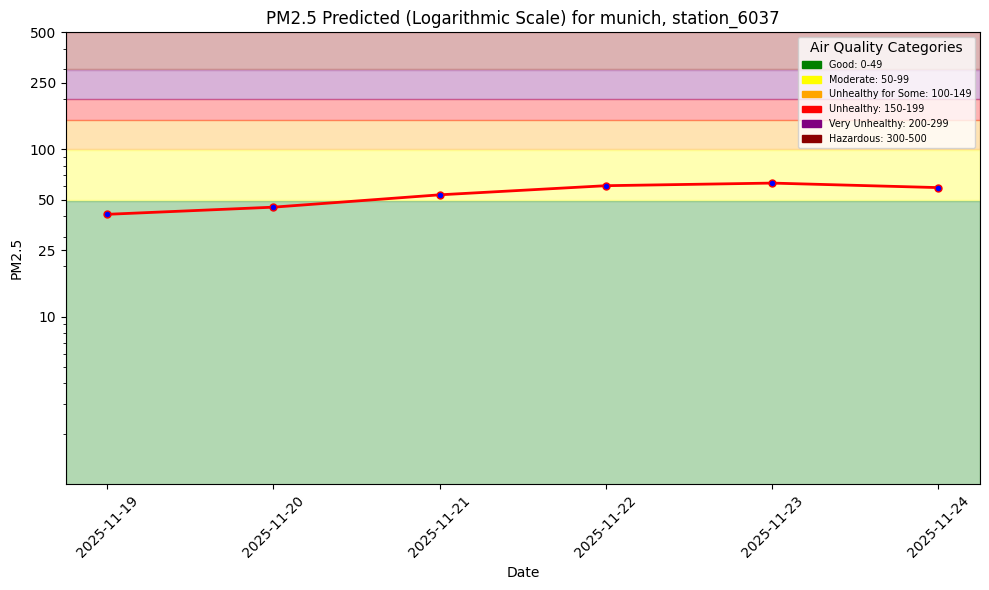

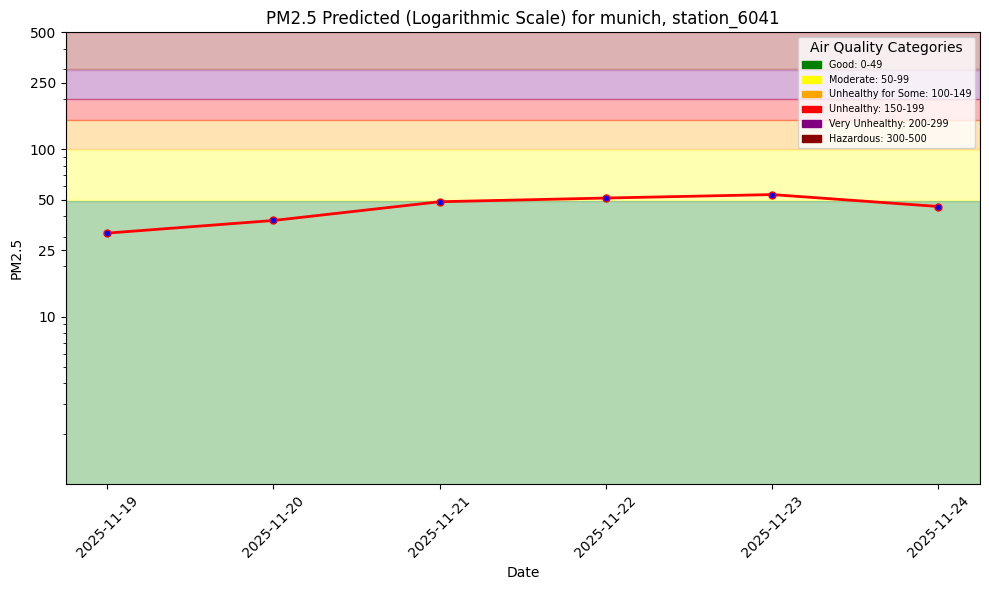

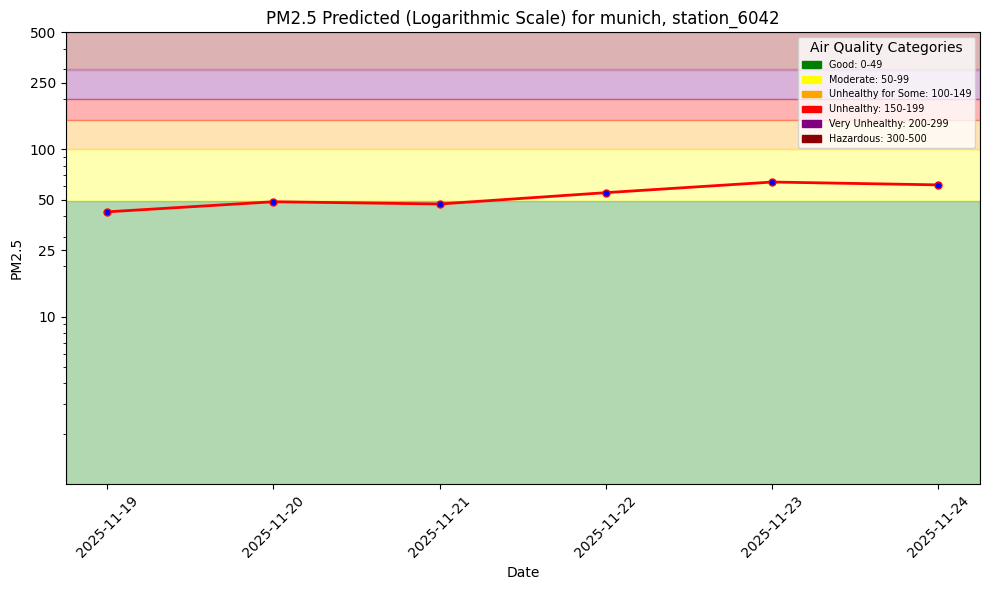

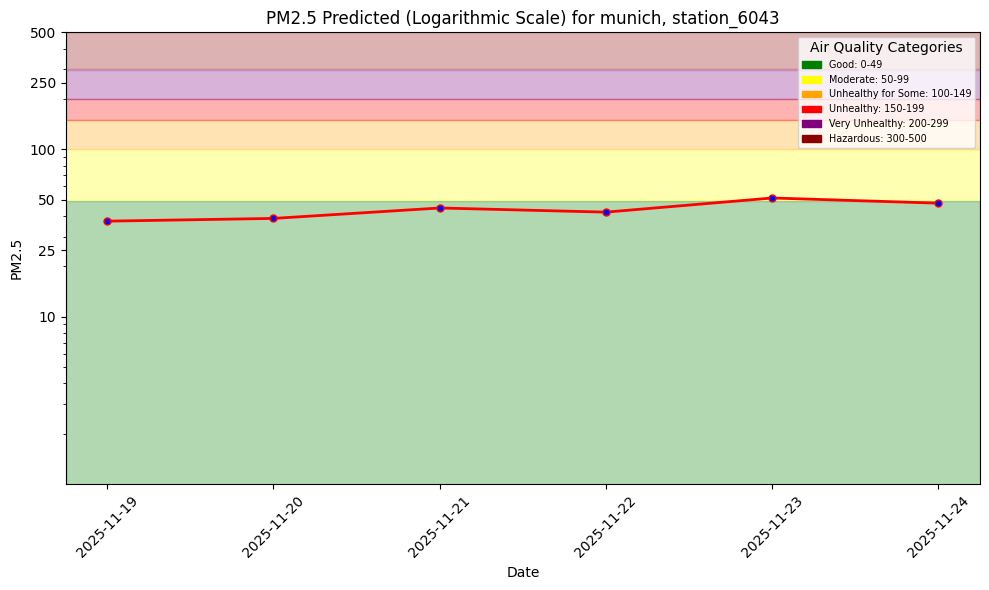

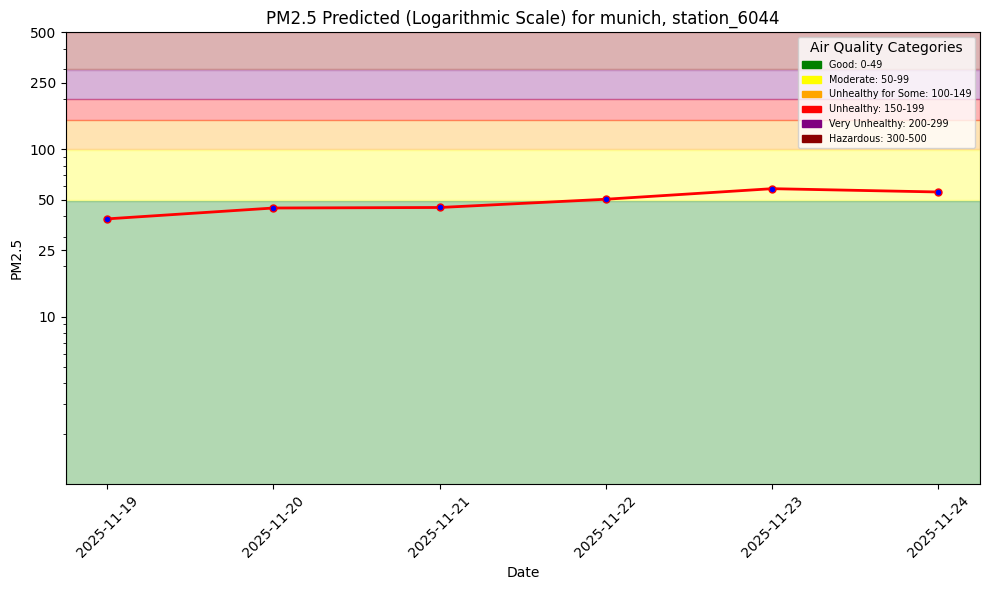

In [21]:
# # Plotting per station 
for sid in sorted(batch_data["station_id"].unique()):
    sensor_df = (
        batch_data[batch_data["station_id"] == sid]
        .sort_values("date")
        .reset_index(drop=True)
    )

    sensor_label = f"station_{int(sid)}"
    sensor_pred_path = (
        f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{sensor_label}.png"
    )

    util.plot_air_quality_forecast(
        city,
        sensor_label,
        sensor_df,
        sensor_pred_path,
    )
    plt.show()

In [15]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=3,
    primary_key=['city', 'street', 'station_id', 'date', 'days_before_forecast_day'],
    event_time="date"
)

In [16]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 30/30 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286301/jobs/named/aq_predictions_3_offline_fg_materialization/executions
2025-11-18 17:12:54,120 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 17:13:00,501 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 17:15:21,530 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 17:15:21,706 INFO: Waiting for log aggregation to finish.
2025-11-18 17:15:47,382 INFO: Execution finished successfully.


(Job('aq_predictions_3_offline_fg_materialization', 'SPARK'), None)

In [17]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.33s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,station_id,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,4.750000,0.000000,4.896529,162.897186,munich,6044.0,21.0,33.0,45.0,38.413574,"Stachus, München, Germany",germany,1
1,2025-11-19 00:00:00+00:00,4.750000,0.000000,4.896529,162.897186,munich,6037.0,NaN,34.0,47.0,40.898365,Munich,germany,1
2,2025-11-19 00:00:00+00:00,4.750000,0.000000,4.896529,162.897186,munich,6042.0,34.0,41.0,41.0,42.316105,"Landshuter Allee, München, Germany",germany,1
3,2025-11-19 00:00:00+00:00,4.750000,0.000000,4.896529,162.897186,munich,6041.0,17.0,33.0,38.0,31.575855,"Johanneskirchen, München, Germany",germany,1
4,2025-11-19 00:00:00+00:00,4.750000,0.000000,4.896529,162.897186,munich,6043.0,25.0,23.0,36.0,37.230106,"Lothstraße, München, Germany",germany,1
5,2025-11-16 00:00:00+00:00,9.286082,0.500000,11.200571,210.308701,munich,6044.0,33.0,45.0,66.0,27.251417,"Stachus, München, Germany",germany,1
6,2025-11-17 00:00:00+00:00,5.275666,7.799999,20.448032,276.300629,munich,6037.0,34.0,47.0,69.0,25.089815,Munich,germany,1
7,2025-11-18 00:00:00+00:00,2.650000,0.000000,1.080000,90.000000,munich,6041.0,33.0,38.0,61.0,42.525616,"Johanneskirchen, München, Germany",germany,1
8,2025-11-15 00:00:00+00:00,9.925667,0.100000,18.435726,190.194168,munich,6044.0,33.0,45.0,66.0,41.672916,"Stachus, München, Germany",germany,1
9,2025-11-17 00:00:00+00:00,5.275666,7.799999,20.448032,276.300629,munich,6044.0,33.0,45.0,66.0,21.421974,"Stachus, München, Germany",germany,1


In [20]:
# Actual outcomes per station
outcome_df = air_quality_df[['date', 'station_id', 'pm25']]

# Predictions per station
preds_df = monitoring_df[['date', 'station_id', 'predicted_pm25']]

# Merge on date + station
hindcast_df = pd.merge(
    preds_df,
    outcome_df,
    on=["date", "station_id"],
    how="inner"
)

hindcast_df = hindcast_df.sort_values(by=['date', 'station_id'])

if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(
        weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model
    )

hindcast_df

,date,station_id,predicted_pm25,pm25
9,2025-11-15 00:00:00+00:00,6037.0,43.430431,69.0
17,2025-11-15 00:00:00+00:00,6041.0,40.357853,61.0
6,2025-11-15 00:00:00+00:00,6042.0,39.678482,55.0
16,2025-11-15 00:00:00+00:00,6043.0,28.843340,55.0
3,2025-11-15 00:00:00+00:00,6044.0,41.672916,66.0
5,2025-11-16 00:00:00+00:00,6037.0,30.247858,47.0
14,2025-11-16 00:00:00+00:00,6041.0,24.773088,38.0
12,2025-11-16 00:00:00+00:00,6042.0,32.909294,41.0
10,2025-11-16 00:00:00+00:00,6043.0,21.279156,36.0
0,2025-11-16 00:00:00+00:00,6044.0,27.251417,45.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

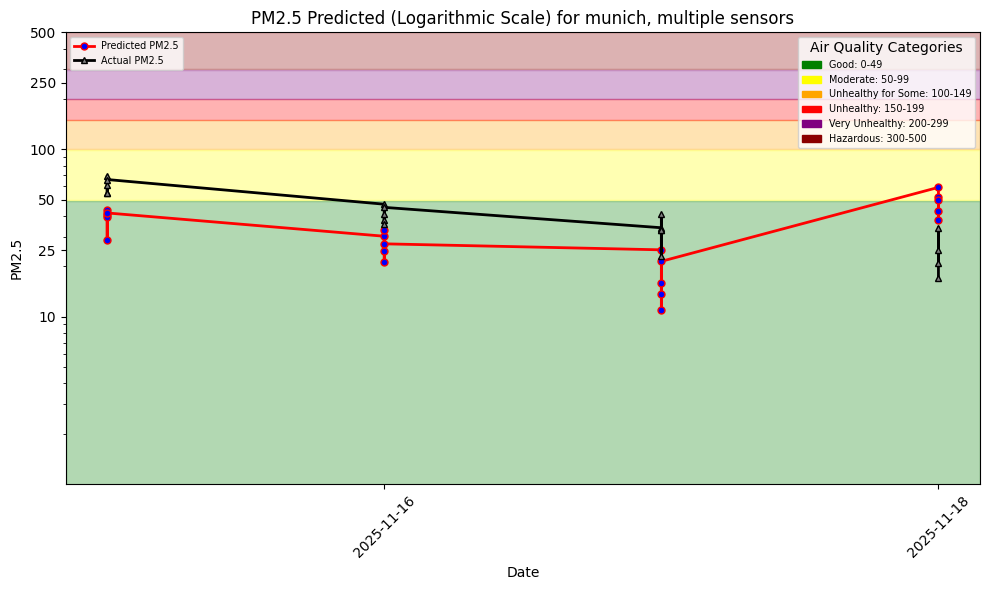

In [22]:
# hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
# plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
# plt.show()

hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
util.plot_air_quality_forecast(
    city,
    "multiple sensors",
    hindcast_df,
    hindcast_file_path,
    hindcast=True
)
plt.show()

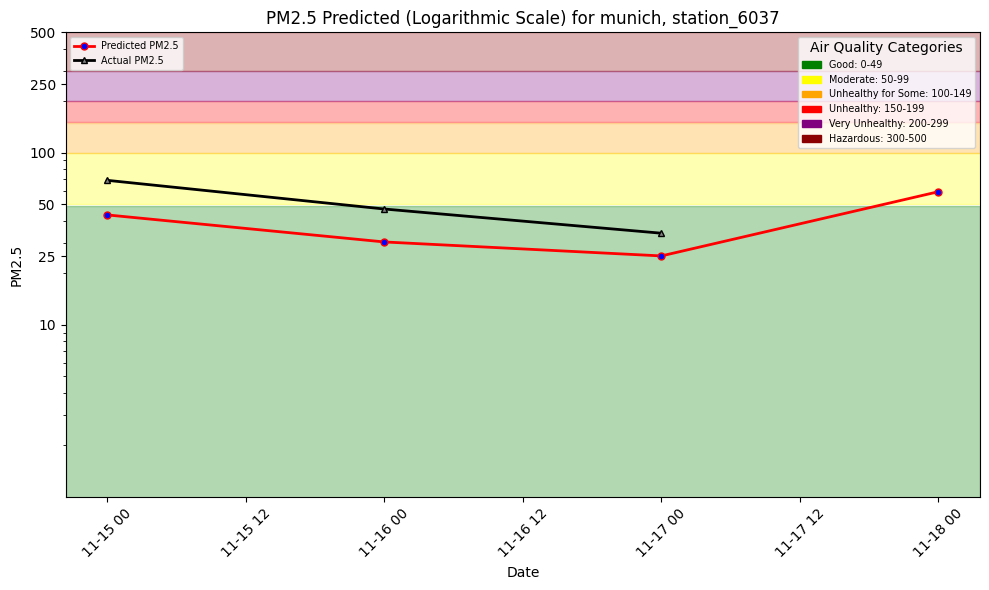

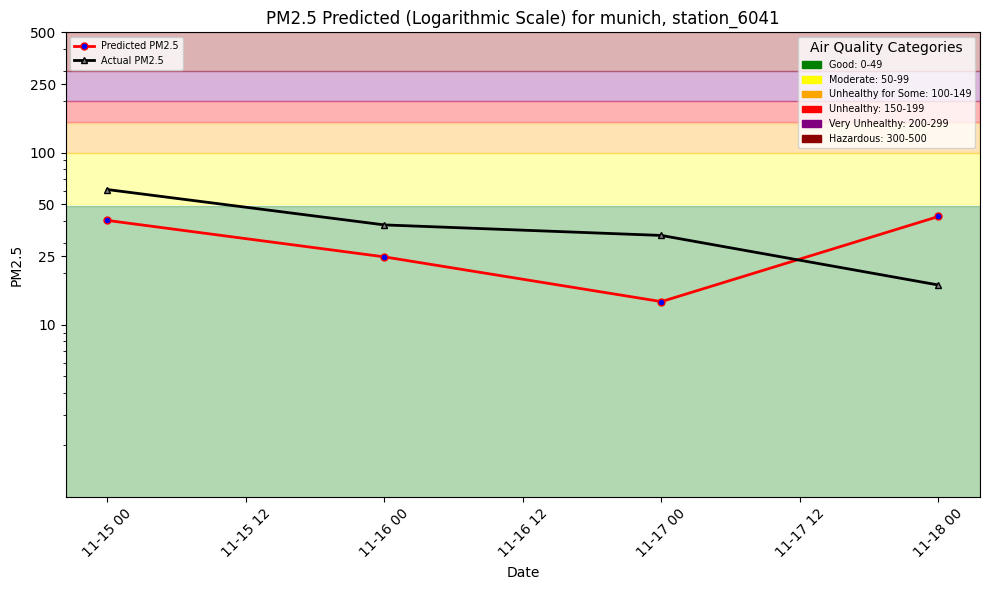

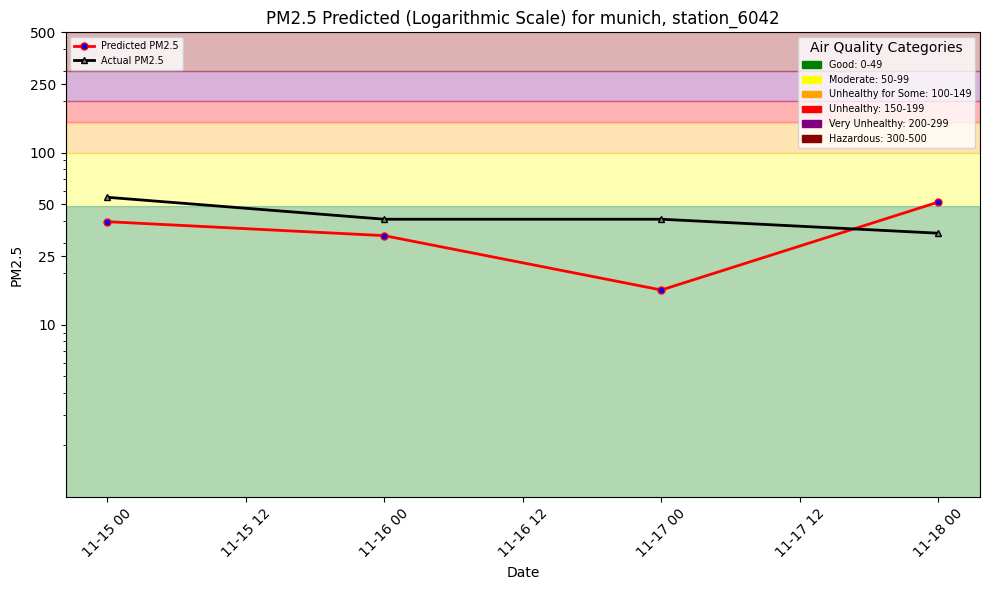

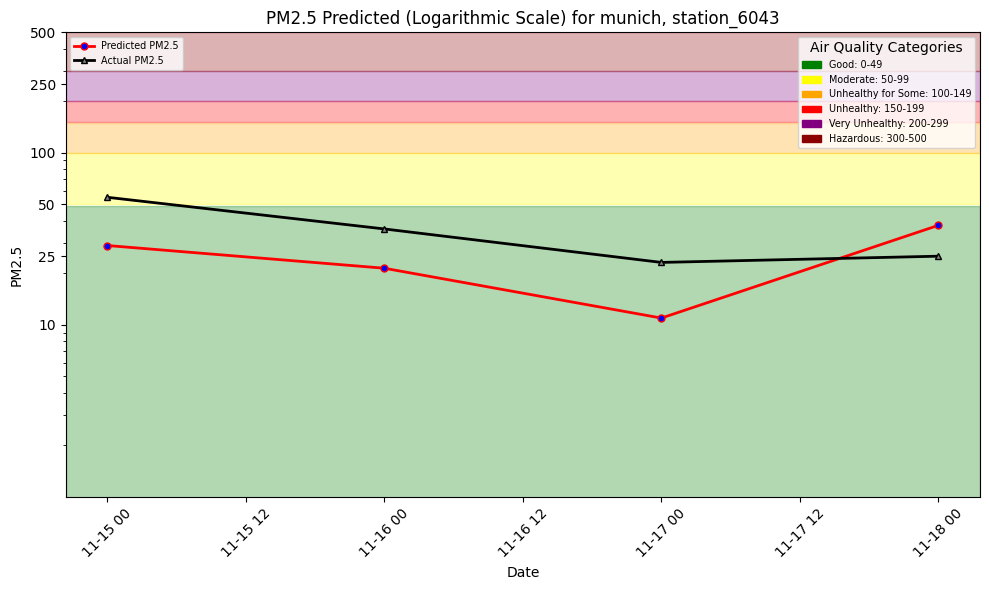

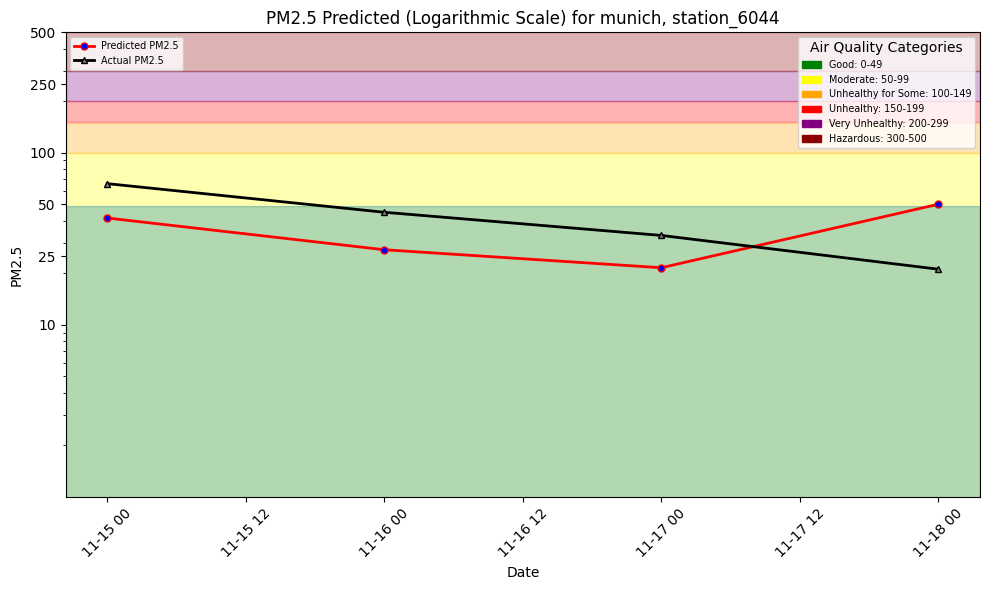

In [23]:
# Plotting per station
for sid in sorted(hindcast_df["station_id"].unique()):
    sensor_hind = (
        hindcast_df[hindcast_df["station_id"] == sid]
        .sort_values("date")
        .reset_index(drop=True)
    )

    sensor_label = f"station_{int(sid)}"
    sensor_hind_path = (
        f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{sensor_label}.png"
    )

    util.plot_air_quality_forecast(
        city,
        sensor_label,
        sensor_hind,
        sensor_hind_path,
        hindcast=True,
    )
    plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [24]:
# dataset_api = project.get_dataset_api()
# str_today = today.strftime("%Y-%m-%d")
# if dataset_api.exists("Resources/airquality") == False:
#     dataset_api.mkdir("Resources/airquality")
# dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
# dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

# proj_url = project.get_url()
# print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")

if not dataset_api.exists("Resources/airquality"):
    dataset_api.mkdir("Resources/airquality")

dataset_api.upload(
    pred_file_path,
    f"Resources/airquality/{city}_multisensor_{str_today}_forecast.png",
    overwrite=True,
)
dataset_api.upload(
    hindcast_file_path,
    f"Resources/airquality/{city}_multisensor_{str_today}_hindcast.png",
    overwrite=True,
)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/fredrikstrom/Documents/KTH_Dokument/Scalable ML/labs/mlfs-book/docs/air-quality/assets/img/pm…

Uploading /Users/fredrikstrom/Documents/KTH_Dokument/Scalable ML/labs/mlfs-book/docs/air-quality/assets/img/pm…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286301/settings/fb/path/Resources/airquality


In [25]:
for sid in sorted(batch_data["station_id"].unique()):
    sensor_label = f"station_{int(sid)}"

    # Forecast image
    sensor_pred_path = (
        f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{sensor_label}.png"
    )
    if os.path.exists(sensor_pred_path):
        dataset_api.upload(
            sensor_pred_path,
            f"Resources/airquality/{city}_{sensor_label}_{str_today}_forecast.png",
            overwrite=True,
        )

    # Hindcast image
    sensor_hind_path = (
        f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{sensor_label}.png"
    )
    if os.path.exists(sensor_hind_path):
        dataset_api.upload(
            sensor_hind_path,
            f"Resources/airquality/{city}_{sensor_label}_{str_today}_hindcast.png",
            overwrite=True,
        )

Uploading /Users/fredrikstrom/Documents/KTH_Dokument/Scalable ML/labs/mlfs-book/docs/air-quality/assets/img/pm…

Uploading /Users/fredrikstrom/Documents/KTH_Dokument/Scalable ML/labs/mlfs-book/docs/air-quality/assets/img/pm…

Uploading /Users/fredrikstrom/Documents/KTH_Dokument/Scalable ML/labs/mlfs-book/docs/air-quality/assets/img/pm…

Uploading /Users/fredrikstrom/Documents/KTH_Dokument/Scalable ML/labs/mlfs-book/docs/air-quality/assets/img/pm…

Uploading /Users/fredrikstrom/Documents/KTH_Dokument/Scalable ML/labs/mlfs-book/docs/air-quality/assets/img/pm…

Uploading /Users/fredrikstrom/Documents/KTH_Dokument/Scalable ML/labs/mlfs-book/docs/air-quality/assets/img/pm…

Uploading /Users/fredrikstrom/Documents/KTH_Dokument/Scalable ML/labs/mlfs-book/docs/air-quality/assets/img/pm…

Uploading /Users/fredrikstrom/Documents/KTH_Dokument/Scalable ML/labs/mlfs-book/docs/air-quality/assets/img/pm…

Uploading /Users/fredrikstrom/Documents/KTH_Dokument/Scalable ML/labs/mlfs-book/docs/air-quality/assets/img/pm…

Uploading /Users/fredrikstrom/Documents/KTH_Dokument/Scalable ML/labs/mlfs-book/docs/air-quality/assets/img/pm…

---